In [1]:
!pip install ultralytics Roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 34.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 95.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import cv2
import torch
import yaml
import math 
import time
import pandas as pd
import numpy as np
from roboflow import Roboflow
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display, Image, clear_output
from PIL import Image

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
print(f"The pytorch verison is : {torch.__version__}")
print(f"The CUDA is available or not : {torch.cuda.is_available()}")
print(f"How many GPU is available :{torch.cuda.device_count()}")
print(f"Name of using GPU is : {torch.cuda.get_device_name()}")

# display using gpu info 
a=!nvidia-smi
print("The using GPU information :")
print("\n".join(a))

The pytorch verison is : 2.6.0+cu124
The CUDA is available or not : True
How many GPU is available :2
Name of using GPU is : Tesla T4
The using GPU information :
Thu Jun 26 04:12:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       3MiB /  15360MiB |  

# **Download Dataset from Roboflow :**

In [4]:
private_api_key="MrxQVHpTMv81YWVp7O2Y"
workspace_name="rayans-lab"
proj_name="track-object-ezawf"
dataset_version=3

In [5]:
def prepare_and_download_dataset(private_api_key,workspace_name, proj_name, dataset_version):
    if not private_api_key or not workspace_name or not proj_name or not dataset_version:
        print("Some information has not been given about roboflow")
        return None
        
    print (f"Downloading custom dataset from roboflow [{workspace_name}]:")

    try:
        # initializing roboflow clint
        try:
            rf=Roboflow(api_key=private_api_key)
        except Exception as e:
            print(f"Error occurred during initializing roboflow client: {e}")
            return None 

        # try to access workspace 
        try:
            work_space=rf.workspace(workspace_name)
        except Exception as e:
            print(f"Error occurred during access to workspace {workspace_name}: {e}")
            return None 

        # try to access project
        try:
            pro_name= work_space.project(proj_name)
        except Exception as e:
            print(f"Error occurred during access to project {proj_name}: {e}")
            return None 

        # download the dataset
        try:
            dataset=pro_name.version(dataset_version).download("yolov12")
        except Exception as e:
            print(f"Error occurred during download the dataset version {dataset_version}: {e}")
            return None 
    
        dataset_path = dataset.location 

        # Open the data.ymal file and recheck and update the train valid and test image data path 
        try:
            with open(os.path.join(dataset_path, "data.yaml"), 'r') as f :
                data = yaml.safe_load(f)

            data["train"]=os.path.join(dataset_path, "train/images")
            data["val"]=os.path.join(dataset_path, "valid/images")
            data["test"]=os.path.join(dataset_path, "test/images")

            with open(os.path.join(dataset_path, "data.yaml"), 'w') as f :
                yaml.dump(data, f)
        except Exception as e:
            print(f"Error occurred during update the data.yaml file: {e}")
            return None        

        # Information about dataset 
        print(f"Number of class : {len(data['names'])}")
        print(f"Name of all classes : {data['names']}")
        print(f"Total number of training images : {len(os.listdir(data['train']))}")
        print(f"Total number of valid images : {len(os.listdir(data['val']))}")
        print(f"Total number of test images : {len(os.listdir(data['test']))}")

        return  dataset_path

    except Exception as e:
        print(f"Error occurred during download the dataset: {e}")
        return None 

In [6]:
# Download and Prepare Dataset
dataset_path = prepare_and_download_dataset(private_api_key=private_api_key,
                                            workspace_name=workspace_name, 
                                            proj_name=proj_name, 
                                            dataset_version=dataset_version)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Track-Object-3 in yolov12:: 100%|██████████| 252/252 [00:00<00:00, 5389.71it/s]


Number of class : 2
Name of all classes : ['Box', 'Cement Beg']
Total number of training images : 105
Total number of valid images : 10
Total number of test images : 5


# Fine-Tune YOLOv11m Model :

In [7]:
def fine_tune_function(dataset_path, model_name, epochs, batch_size, proj_dir, run_name):
    if not dataset_path:
        print("dataset_path cant found")
        return None, None, None
    
    # load the YOLOv11n pretrained model 
    try:
        print("Loading the model from ultralytics :")
        model=YOLO(model_name)
    except Exception as e:
        print(f"Error occurred during load the model: {e}")
        return None, None, None

    # create project directory 
    try:
        print("creating project directory :")
        results_dir=os.path.join(proj_dir, run_name)
        print(f"Project directory has been created to this [{results_dir}] path.")
    except Exception as e:
        print(f"Error occurred during creating project project directory: {e}")
        return None, None, None
        
    # fine tune the model
    try:
        print(f"The training results will be saved to this [{results_dir}] path.")
        print("Starting The Training..................................................................")
        start_time=time.time()
        results=model.train(data=os.path.join(dataset_path, "data.yaml"),
                            seed=42,
                            epochs=epochs,
                            patience=100,
                            batch=batch_size,
                            imgsz=640,
                            device=0, # for multi GPU device=[0,1]
                            workers=4,

                            # Ultralytice by defult augmentation parameters
                             degrees=10.0,  # Rotattion (±10°)
                             flipud=0.9,    # No vertical flip
                             fliplr=0.9,    # Horizontal flip (90% chance)
                            # hsv_h=0.0,     # No hue change
                            # hsv_s=0.0,     # No saturation change
                             hsv_v=0.4,     # Contrast adjustment (brightness)
                            # translate=0.0, # No translate
                            # scale=0.0,     # No scaling
                            # shear=0.0,     # No shearing
                            # perspective=0.0, # No perspective
                            # mosaic=0.0,    # Disable mosaic
                            # mixup=0.0,     # Disable mixup
                            # copy_paste=0.0,# Disable copy_paste
        
                            # Other training parameters
                            lr0=0.001,
                            lrf=0.1,
                            momentum=0.98,
                            weight_decay=0.005,
                            warmup_epochs=3,
                            warmup_momentum=0.9,
                            warmup_bias_lr=0.1,
                            cos_lr=True,

                            # Validation & Saving
                            save=True,
                            #save_period=10,
                            val=True,
                            plots=True,
                           
                            # Project Organizing 
                            exist_ok=True, # allows overwriting of an existing project/name directory
                            project=proj_dir, # name of the project directory where training outputs are saved
                            name=run_name, # used for creating a subdirectory within the project folder, where training logs and outputs are stored
                           
                            verbose=True)   
        
        total_training_time=time.time()-start_time
        print(f"Training has been completed.\nTotal training time : {total_training_time:.2f} sec, {total_training_time/60:.2f} min, {total_training_time/3600:.2f} hours")
    except Exception as e:
        print(f"Error occurred during train the model: {e}")
        return None, None, None

    # Save the best model in the dedicated path 
    try:
        print("Saving the fine tune model :")
        best_model_path=os.path.join(proj_dir, run_name, "weights/best.pt")
        if os.path.exists(best_model_path): 
            print(f"The fine tune model has been saved to this [{best_model_path}] path")
        else:
            print(f"WARNING-The fine tune model has 'NOT' been saved to this [{best_model_path}] path")
            return None,None, None
    except Exception as e:
        print(f"Error occurred during save the fine tune model: {e}")
        return None, None, None

    return best_model_path, run_name, results

In [8]:
# Fine tune the model using own custome dataset
best_model_path, run_name, training_results = fine_tune_function(dataset_path="/kaggle/working/Track-Object-3", 
                   model_name="yolo11m.pt" , 
                   epochs=300, 
                   batch_size=-1, # this will automatically determines the optimal batch size based on available GPU memory                     
                   proj_dir="/kaggle/working/runs/detect",
                   run_name="Factory-Production-Line-Objects-Detect-Track-And-Count")

Loading the model from ultralytics :


100%|██████████| 38.8M/38.8M [00:00<00:00, 232MB/s]


creating project directory :
Project directory has been created to this [/kaggle/working/runs/detect/Factory-Production-Line-Objects-Detect-Track-And-Count] path.
The training results will be saved to this [/kaggle/working/runs/detect/Factory-Production-Line-Objects-Detect-Track-And-Count] path.
Starting The Training..................................................................
Ultralytics 8.3.159 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/Track-Object-3/data.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=True, fliplr=0.9, flipud=0.9, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=

100%|██████████| 755k/755k [00:00<00:00, 18.5MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 79.7MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1429.6±751.1 MB/s, size: 94.8 KB)


train: Scanning /kaggle/working/Track-Object-3/train/labels... 105 images, 0 backgrounds, 0 corrupt: 100%|██████████| 105/105 [00:00<00:00, 1292.85it/s]

train: New cache created: /kaggle/working/Track-Object-3/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.74G total, 0.21G reserved, 0.21G allocated, 14.32G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    20054550       68.19         1.671         63.62         298.4        (1, 3, 640, 640)                    list
    20054550       136.4         2.330         49.29         124.8        (2, 3, 640, 640)                    list
    20054550       272.8         3.397         55.17         134.5        (4, 3, 640, 640)                    list
    20054550       545.5         5.570         89.17         178.1        (8, 3, 640, 640)                    list
    20054550        1091         9.

train: Scanning /kaggle/working/Track-Object-3/train/labels.cache... 105 images, 0 backgrounds, 0 corrupt: 100%|██████████| 105/105 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.1 ms, read: 735.0±376.5 MB/s, size: 66.5 KB)


val: Scanning /kaggle/working/Track-Object-3/valid/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 1813.83it/s]

val: New cache created: /kaggle/working/Track-Object-3/valid/labels.cache


Plotting labels to /kaggle/working/runs/detect/Factory-Production-Line-Objects-Detect-Track-And-Count/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.98' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0054687500000000005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /kaggle/working/runs/detect/Factory-Production-Line-Objects-Detect-Track-And-Count
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      7.06G      1.961      4.214      2.047         23        640: 100%|██████████| 8/8 [00:04<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         10        231      0.557      0.333      0.404      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      7.07G      1.401      1.878      1.323         27        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]

                   all         10        231      0.745      0.753      0.761      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      7.13G      1.248      1.234      1.185         54        640: 100%|██████████| 8/8 [00:03<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


                   all         10        231      0.613      0.485      0.572      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300       7.2G      1.177      1.076      1.149         37        640: 100%|██████████| 8/8 [00:03<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


                   all         10        231      0.717      0.723       0.78      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      7.27G      1.182      1.037      1.183         38        640: 100%|██████████| 8/8 [00:03<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]

                   all         10        231      0.687      0.666      0.708       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      7.33G      1.171     0.9968      1.183         23        640: 100%|██████████| 8/8 [00:03<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]

                   all         10        231      0.768      0.628        0.7      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      7.44G      1.195      1.024      1.183         66        640: 100%|██████████| 8/8 [00:03<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]

                   all         10        231      0.639      0.688      0.609      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      7.19G      1.164     0.9814      1.158        108        640: 100%|██████████| 8/8 [00:03<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.35it/s]

                   all         10        231      0.629      0.623      0.658      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      7.27G      1.189     0.9882      1.178         21        640: 100%|██████████| 8/8 [00:03<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]

                   all         10        231      0.462       0.42      0.415      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      7.33G        1.2      1.021      1.174         43        640: 100%|██████████| 8/8 [00:03<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]

                   all         10        231      0.552      0.719      0.611      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300       7.4G      1.274      1.116      1.205         43        640: 100%|██████████| 8/8 [00:03<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

                   all         10        231      0.465      0.762      0.661      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      7.27G      1.276     0.9695       1.22         48        640: 100%|██████████| 8/8 [00:03<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


                   all         10        231      0.575       0.58       0.57      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      7.33G      1.184     0.9721       1.16         40        640: 100%|██████████| 8/8 [00:03<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]

                   all         10        231      0.628      0.485      0.539      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      7.39G      1.326      1.086      1.258         63        640: 100%|██████████| 8/8 [00:03<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.68it/s]

                   all         10        231      0.612      0.623      0.641      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300       7.2G      1.233     0.9542      1.196         45        640: 100%|██████████| 8/8 [00:03<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

                   all         10        231      0.578        0.7      0.649       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      7.25G      1.053     0.8526      1.106         29        640: 100%|██████████| 8/8 [00:03<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


                   all         10        231      0.753      0.767      0.777      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      7.34G      1.134     0.8556      1.167         46        640: 100%|██████████| 8/8 [00:03<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


                   all         10        231      0.767      0.719      0.774      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300       7.4G      1.097     0.7356      1.141         67        640: 100%|██████████| 8/8 [00:03<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]

                   all         10        231      0.763      0.701      0.735      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      7.28G      1.087     0.7306      1.144         51        640: 100%|██████████| 8/8 [00:03<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]

                   all         10        231       0.81      0.775      0.829      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      7.33G      1.069     0.7084      1.118         32        640: 100%|██████████| 8/8 [00:03<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


                   all         10        231      0.849      0.778      0.861      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      7.38G      1.121     0.7274       1.17         82        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]

                   all         10        231      0.782      0.791      0.836      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      7.26G      1.091     0.7981      1.168         17        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


                   all         10        231      0.825      0.771      0.869      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      7.31G      1.077     0.7451      1.133         30        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]

                   all         10        231      0.853      0.778      0.842      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      7.38G      1.052     0.6837      1.113         50        640: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]

                   all         10        231      0.806      0.801      0.851       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      7.19G      1.066     0.6726      1.133         32        640: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


                   all         10        231      0.816      0.775      0.875      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      7.24G      1.043     0.6561      1.116         33        640: 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


                   all         10        231      0.797      0.765      0.838      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      7.33G      1.053     0.6706      1.094        113        640: 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


                   all         10        231      0.826      0.718      0.799      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      7.39G      1.038     0.6341      1.106         76        640: 100%|██████████| 8/8 [00:03<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

                   all         10        231      0.829      0.784      0.837      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      7.28G      1.034     0.6859      1.131         42        640: 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]

                   all         10        231      0.683      0.785      0.783      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      7.34G      1.022     0.6439      1.093         17        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


                   all         10        231      0.737      0.788      0.813      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      7.39G      1.051     0.6927       1.09         26        640: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

                   all         10        231       0.74      0.839      0.829      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      7.27G      1.063     0.6631      1.097         36        640: 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


                   all         10        231      0.792      0.818      0.866      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      7.33G      1.017     0.6719      1.089         39        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

                   all         10        231      0.819      0.814       0.87      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      7.39G     0.9975     0.6213      1.071         20        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

                   all         10        231      0.566       0.26       0.28      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300       7.2G      0.998     0.7105        1.1         46        640: 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]

                   all         10        231       0.76      0.602       0.68      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      7.24G      1.015     0.6545      1.098         20        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]

                   all         10        231      0.757      0.524      0.557      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      7.33G     0.9716     0.6814      1.066         42        640: 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]

                   all         10        231      0.856      0.481      0.508      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      7.39G      1.003     0.6433       1.09         46        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]

                   all         10        231      0.753      0.576      0.601      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      7.24G       1.02     0.7185      1.131         37        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]

                   all         10        231      0.792      0.732      0.825      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      7.31G      1.013     0.6257      1.093         63        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


                   all         10        231       0.82      0.772      0.841      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      7.36G      1.019     0.6455      1.111         36        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


                   all         10        231      0.782      0.763       0.84      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      7.23G      1.017     0.6646      1.111         33        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]

                   all         10        231      0.853      0.727      0.857      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      7.23G      1.011     0.6438      1.082         50        640: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


                   all         10        231      0.833      0.796      0.871      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      7.27G      0.964     0.6246      1.055         34        640: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]

                   all         10        231      0.898      0.792      0.868      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      7.34G     0.9665     0.6266      1.107         11        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]

                   all         10        231      0.884      0.827      0.884      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      7.39G     0.9916     0.6864      1.093         27        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]

                   all         10        231      0.882      0.808      0.884      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      7.29G     0.9399     0.6138      1.061         22        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]

                   all         10        231       0.85      0.848      0.901      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      7.34G     0.9172      0.568      1.051         30        640: 100%|██████████| 8/8 [00:03<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]

                   all         10        231      0.831      0.879      0.879      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300       7.4G      1.004     0.5969      1.112         20        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.68it/s]

                   all         10        231      0.685      0.121      0.204      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      7.19G     0.9656     0.6075      1.097         25        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]

                   all         10        231     0.0523      0.039     0.0282    0.00776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      7.24G     0.9215     0.5951      1.051         34        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]

                   all         10        231      0.799      0.472      0.582      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      7.32G     0.9116     0.5967      1.061         67        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


                   all         10        231      0.735       0.65      0.723      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      7.39G     0.9064     0.5586      1.068         33        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.91it/s]

                   all         10        231      0.783      0.801      0.838      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      7.29G     0.9462     0.5997      1.078         22        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

                   all         10        231       0.79      0.671      0.743      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      7.35G     0.9173     0.5879      1.038         33        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]

                   all         10        231      0.786      0.731      0.799      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      7.39G     0.8953     0.5622       1.04         55        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]

                   all         10        231      0.865      0.836      0.898      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      7.27G     0.9042     0.5456      1.033         45        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]

                   all         10        231      0.845      0.709      0.803      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      7.32G     0.9207     0.5619       1.03         72        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


                   all         10        231      0.896      0.747      0.843      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      7.39G     0.9346       0.55      1.061         35        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]

                   all         10        231      0.879      0.848      0.901      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      7.22G     0.8763     0.5719      1.035         38        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]

                   all         10        231      0.853      0.856      0.887      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      7.27G     0.8975     0.5605      1.027         27        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]

                   all         10        231      0.922      0.883      0.928      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      7.36G     0.8338     0.5067     0.9992         49        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]

                   all         10        231      0.935      0.868      0.934       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      7.18G     0.9079     0.5483       1.02         48        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


                   all         10        231      0.859      0.896      0.911      0.679

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300       7.2G     0.8898     0.5565       1.05         41        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]

                   all         10        231      0.895      0.886      0.916      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      7.26G     0.8453     0.5432      1.053         18        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


                   all         10        231      0.939      0.861      0.918      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      7.31G     0.8718     0.5506       1.02         70        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]

                   all         10        231       0.89      0.896       0.93      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300       7.4G     0.8796     0.5535      1.042         21        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]

                   all         10        231      0.884      0.874      0.923      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      7.22G      0.859     0.5393      1.024         51        640: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]

                   all         10        231       0.87      0.784      0.877      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      7.27G     0.8857     0.5692      1.036         27        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]

                   all         10        231      0.826      0.822      0.869      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      7.34G     0.8632     0.5171      1.021         28        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


                   all         10        231      0.851      0.818      0.878      0.618

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      7.39G     0.8895     0.5641      1.049         36        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]

                   all         10        231      0.828      0.854      0.903       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      7.27G     0.8596     0.4961      1.034         39        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


                   all         10        231      0.846      0.909      0.923      0.672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      7.31G     0.8378     0.5105      1.014         18        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]

                   all         10        231      0.923      0.833      0.915      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      7.38G     0.8427      0.521      1.024         31        640: 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]

                   all         10        231      0.867      0.835      0.896      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      7.19G      0.814     0.5217       1.01         62        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]

                   all         10        231      0.881       0.84      0.907      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      7.24G     0.8796     0.5279       1.02         34        640: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]

                   all         10        231      0.915      0.887      0.927      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      7.33G     0.8078     0.4963     0.9974         21        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]

                   all         10        231      0.903      0.874      0.923      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      7.39G     0.8557     0.5135      1.029         36        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]

                   all         10        231      0.907      0.887      0.933      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300       7.3G     0.8536     0.5611      1.023         27        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]

                   all         10        231      0.907      0.844      0.926      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      7.37G     0.8273     0.4989      1.011         96        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]

                   all         10        231      0.902      0.837      0.922       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      7.18G      0.789     0.4914     0.9825         27        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]

                   all         10        231      0.915      0.814      0.899      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      7.19G      0.881     0.5188      1.015         24        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]

                   all         10        231      0.926      0.861       0.91      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      7.26G     0.8181     0.4903      1.007         32        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]

                   all         10        231      0.915       0.87      0.913      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      7.32G     0.7879     0.5012     0.9923         42        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]

                   all         10        231      0.916      0.853      0.912      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      7.39G     0.7895     0.4813     0.9986         97        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

                   all         10        231      0.881      0.866      0.903       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      7.26G     0.8063     0.5094      1.001         28        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]

                   all         10        231      0.861      0.848      0.897      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      7.32G        0.8     0.4877     0.9906         53        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


                   all         10        231      0.863      0.874      0.905      0.681

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      7.39G     0.8063     0.4895     0.9981         25        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]

                   all         10        231      0.882      0.874       0.92      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      7.24G     0.7954     0.4941     0.9907         38        640: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]

                   all         10        231      0.935      0.866      0.924      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      7.31G     0.7885     0.4819      1.003         22        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]

                   all         10        231      0.914      0.857      0.915      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      7.36G     0.7878     0.4767      0.995         29        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]

                   all         10        231      0.909      0.864      0.919      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      7.24G     0.7703     0.4514     0.9762         42        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]

                   all         10        231      0.871      0.892      0.918      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      7.24G     0.7576     0.4585     0.9767         48        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]

                   all         10        231      0.846      0.878      0.906       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300       7.3G     0.7802      0.477      1.004         27        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]

                   all         10        231      0.861      0.879      0.928      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      7.36G     0.7957     0.4666     0.9746         65        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


                   all         10        231      0.913      0.822      0.918      0.696

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300       7.2G     0.8601     0.4993       1.02         55        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]

                   all         10        231      0.918       0.78      0.902      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      7.22G     0.8313     0.4728          1         67        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]

                   all         10        231      0.904      0.775      0.886      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      7.29G     0.8012     0.4559     0.9882         35        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]

                   all         10        231      0.878      0.732      0.856      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      7.35G     0.8567     0.4998      1.026         34        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]

                   all         10        231      0.893      0.823      0.889      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      7.42G     0.8212     0.4752      1.019         62        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]

                   all         10        231      0.868      0.857      0.902      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      7.23G     0.7937     0.4548      1.017         23        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]

                   all         10        231      0.895      0.831       0.91      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      7.29G     0.7255     0.4421     0.9694         29        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]

                   all         10        231      0.918       0.81      0.919      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      7.36G      0.779     0.4269     0.9952         33        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


                   all         10        231      0.872      0.856      0.912      0.678

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      7.21G      0.748     0.4547     0.9735         52        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]

                   all         10        231       0.89      0.878      0.931      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      7.21G     0.7325     0.4367     0.9554         27        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


                   all         10        231      0.876      0.887      0.928      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      7.26G     0.7639     0.4577     0.9926         24        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]

                   all         10        231      0.875      0.877      0.935      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      7.35G     0.7838     0.4616     0.9916         23        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]

                   all         10        231      0.868      0.885      0.936      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      7.18G     0.7601     0.4504     0.9998         29        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]

                   all         10        231      0.901      0.865       0.93      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      7.19G     0.7559     0.4355     0.9592         27        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]

                   all         10        231      0.879       0.88      0.928      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      7.26G     0.7812     0.4457      1.001         41        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]

                   all         10        231      0.877      0.898      0.934      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300       7.3G     0.7579       0.44     0.9884         35        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]

                   all         10        231      0.878      0.883      0.931       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      7.39G     0.7363     0.4263     0.9674         33        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]

                   all         10        231      0.893      0.879      0.924      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300      7.32G      0.713     0.4174     0.9562         29        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


                   all         10        231      0.901      0.857      0.925      0.681

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      7.37G     0.7819     0.4418      1.003         29        640: 100%|██████████| 8/8 [00:03<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]

                   all         10        231       0.92      0.848       0.93      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      7.22G     0.7814     0.4437      1.002         19        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]

                   all         10        231      0.919      0.831      0.919      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      7.27G     0.7284     0.4249     0.9642         55        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]

                   all         10        231       0.91      0.818      0.918      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      7.35G     0.6992     0.4086      0.955         55        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]

                   all         10        231      0.922      0.816      0.917      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300       7.2G     0.7385     0.4289     0.9771         27        640: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]

                   all         10        231       0.89       0.87      0.925      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      7.22G     0.6871     0.4039     0.9457         43        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]

                   all         10        231      0.905      0.857      0.928      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300      7.29G     0.7153     0.4152     0.9503         39        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]

                   all         10        231      0.921      0.858       0.93      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      7.34G     0.7007     0.4317     0.9591         44        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]

                   all         10        231      0.911      0.846      0.924      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      7.18G      0.724     0.4397     0.9409         41        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]

                   all         10        231      0.923      0.857      0.935       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      7.19G     0.6804     0.4201     0.9439         45        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]

                   all         10        231      0.887      0.885      0.935      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300      7.25G     0.7167     0.4271      0.964         35        640: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]

                   all         10        231      0.905       0.87       0.93      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      7.32G     0.7301     0.4366     0.9426         79        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]

                   all         10        231      0.893      0.879      0.931      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300      7.37G     0.7506     0.4201     0.9748         43        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]

                   all         10        231      0.892       0.87      0.932      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      7.19G     0.6731     0.4016     0.9147         57        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

                   all         10        231      0.895      0.883      0.932       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      7.19G     0.6599     0.3993     0.9367         35        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.91it/s]

                   all         10        231      0.863      0.901      0.928      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300      7.24G     0.6807     0.3939     0.9427         34        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]

                   all         10        231      0.873      0.895      0.928      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      7.31G     0.6884     0.4163     0.9612         21        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]

                   all         10        231      0.907      0.892      0.934      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300      7.36G      0.689     0.4064     0.9534         35        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]

                   all         10        231      0.888        0.9      0.937      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300      7.23G     0.7691     0.4332     0.9935         42        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]

                   all         10        231      0.947      0.847      0.937      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      7.23G     0.6969      0.412       0.96         27        640: 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

                   all         10        231      0.884      0.887      0.929      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300      7.29G      0.709     0.4214     0.9529         37        640: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]

                   all         10        231      0.868      0.887      0.921      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300      7.36G     0.6873     0.4029     0.9518         44        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]

                   all         10        231       0.89      0.861      0.919      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300       7.2G     0.7228      0.416     0.9662         53        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]

                   all         10        231      0.896      0.861      0.921        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300      7.21G     0.6826     0.4124     0.9587         16        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

                   all         10        231      0.909      0.869      0.918      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      7.27G     0.6925     0.4265     0.9654         27        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]

                   all         10        231      0.922       0.87      0.925      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300      7.34G     0.6675     0.4072     0.9346         78        640: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]

                   all         10        231      0.943      0.857      0.923        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300      7.41G     0.7371     0.4168      1.017         22        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]

                   all         10        231      0.921      0.853      0.923       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300      7.29G     0.6806     0.3952      0.951         50        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]

                   all         10        231      0.895       0.87       0.93      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300      7.34G      0.697     0.4099     0.9565         51        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]

                   all         10        231      0.918      0.853       0.93      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300      7.41G     0.6726     0.4111     0.9473         23        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]

                   all         10        231      0.906      0.853      0.932      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300      7.27G     0.6904      0.403     0.9574         20        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]

                   all         10        231      0.886      0.857      0.921      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300      7.33G     0.6374     0.3862     0.9256         48        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]

                   all         10        231      0.901      0.848      0.915      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      7.38G      0.647     0.3951     0.9347         66        640: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]

                   all         10        231       0.93      0.844      0.911      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300      7.27G     0.6831     0.4178      0.962         50        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]

                   all         10        231      0.916      0.851      0.921      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300      7.33G      0.665      0.394     0.9231         35        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]

                   all         10        231      0.916      0.847      0.914      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300      7.39G     0.6277     0.3856     0.9484         38        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]

                   all         10        231       0.87      0.869      0.914      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300       7.2G     0.6547     0.3952     0.9452         39        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]

                   all         10        231       0.88      0.855      0.915       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300      7.25G     0.6434     0.3828     0.9292         56        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]

                   all         10        231      0.912      0.792      0.904      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300      7.33G     0.6319      0.369     0.9267         23        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]

                   all         10        231      0.921      0.801      0.913       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300       7.4G     0.6746     0.3814     0.9522         22        640: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]

                   all         10        231      0.889      0.866       0.92      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300      7.25G      0.634     0.3643     0.9303         41        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]

                   all         10        231      0.902       0.87      0.925      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300      7.31G     0.6301     0.3585      0.928         17        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]

                   all         10        231      0.896      0.874      0.924       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300      7.36G      0.677     0.4004     0.9507         39        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]

                   all         10        231      0.921      0.844       0.92      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300      7.21G     0.6742     0.4075     0.9511         31        640: 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]

                   all         10        231      0.905      0.853      0.921      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300      7.21G     0.7075     0.3791     0.9469         62        640: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]

                   all         10        231      0.889       0.87      0.925        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300      7.27G     0.6144     0.3628     0.9142         52        640: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]

                   all         10        231      0.901      0.863      0.929      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300      7.33G     0.6811     0.3882     0.9577         45        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]

                   all         10        231      0.913      0.863      0.929      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300      7.38G     0.6417     0.3867     0.9393         45        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]

                   all         10        231      0.918      0.872       0.92      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300      7.27G     0.6577     0.3894     0.9217         15        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]

                   all         10        231      0.939      0.868      0.922      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300       7.3G     0.6546     0.3704     0.9437         24        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]

                   all         10        231      0.934      0.855      0.911      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300      7.37G      0.628      0.384     0.9456         37        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]

                   all         10        231      0.952      0.857      0.918        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300      7.22G     0.6389     0.3688     0.9268         27        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]

                   all         10        231      0.919      0.883      0.922      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300      7.27G     0.6832     0.3817     0.9216         97        640: 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]

                   all         10        231      0.915       0.89      0.932      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300      7.35G     0.6323     0.3738     0.9272         45        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]

                   all         10        231      0.911      0.896      0.936      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300      7.21G      0.639     0.3578     0.9308         36        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]

                   all         10        231      0.879      0.909      0.939      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300      7.22G     0.6226      0.367     0.9573         21        640: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]

                   all         10        231      0.952      0.852      0.942      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300      7.29G     0.6759     0.3676     0.9393         19        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]

                   all         10        231      0.952      0.856      0.944      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300      7.34G     0.6325     0.3663      0.944         27        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]

                   all         10        231       0.94      0.857      0.944      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300      7.14G     0.6185     0.3659     0.9059         72        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]

                   all         10        231      0.941      0.853      0.945      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300      7.14G     0.6073     0.3577     0.9065         51        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.91it/s]

                   all         10        231      0.926      0.866      0.947      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300       7.2G     0.5766     0.3385     0.9127         55        640: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]

                   all         10        231      0.911      0.892      0.944      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300      7.27G     0.5754     0.3435     0.8933         49        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]

                   all         10        231      0.911      0.888      0.942      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300      7.32G     0.6391     0.3519     0.9403         27        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]

                   all         10        231      0.924      0.887       0.94      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300       7.4G     0.5603     0.3267     0.8956         77        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]

                   all         10        231      0.906      0.892      0.937      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300      7.32G     0.5717     0.3507     0.9072         17        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]

                   all         10        231      0.906      0.883      0.935      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300      7.36G     0.5584     0.3382     0.9034         24        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]

                   all         10        231      0.904        0.9      0.939      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300      7.43G     0.5931      0.355     0.9091         36        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]

                   all         10        231      0.928      0.874      0.938      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300      7.28G     0.6088     0.3683     0.9421         41        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

                   all         10        231      0.935       0.87      0.941      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300      7.34G     0.5865      0.347     0.9177         39        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]

                   all         10        231      0.935      0.866      0.944      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300      7.41G     0.5947     0.3396      0.915         31        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]

                   all         10        231      0.937      0.866      0.946      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300      7.28G     0.5725     0.3465     0.9132         11        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]

                   all         10        231       0.93       0.86      0.946       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300      7.34G     0.5478     0.3285     0.9031         34        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


                   all         10        231      0.889      0.899      0.942      0.756

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300      7.39G     0.5674     0.3384     0.8973         48        640: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.07it/s]

                   all         10        231      0.896      0.905      0.945      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300      7.27G     0.5815     0.3418     0.9082         72        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]

                   all         10        231      0.889      0.902      0.944      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300      7.32G     0.5625     0.3355     0.9051         55        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]

                   all         10        231      0.898        0.9      0.942      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300      7.39G     0.5581     0.3382     0.9028         54        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]

                   all         10        231      0.894      0.912       0.94      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300       7.2G     0.5899     0.3556     0.9254         14        640: 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]

                   all         10        231       0.92        0.9      0.938      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300      7.24G     0.5577     0.3291     0.8951         41        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]

                   all         10        231      0.909      0.913      0.936      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300      7.33G     0.5428     0.3312     0.9062         18        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]

                   all         10        231      0.916      0.909      0.937       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/300      7.39G     0.5599     0.3373     0.8892         49        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]

                   all         10        231      0.927      0.896      0.935      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/300      7.26G     0.5395     0.3212        0.9         29        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]

                   all         10        231      0.917      0.906      0.943      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/300      7.32G     0.5524     0.3269     0.9006         21        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]

                   all         10        231      0.936      0.889      0.942      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/300      7.37G     0.5681     0.3382     0.9127         31        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]

                   all         10        231      0.951      0.874      0.941      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/300      7.21G     0.5606     0.3274     0.9154         22        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

                   all         10        231      0.948      0.875      0.941      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/300      7.21G     0.5398     0.3152       0.89         53        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]

                   all         10        231      0.927        0.9      0.941      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/300      7.26G     0.5388     0.3243     0.8854         76        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]

                   all         10        231      0.933        0.9      0.941       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/300      7.33G     0.5829     0.3369     0.9142         24        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]

                   all         10        231      0.933      0.892      0.943      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/300      7.38G      0.561     0.3371     0.8993         53        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]

                   all         10        231      0.913        0.9      0.939      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/300      7.28G     0.5335      0.313     0.8781         22        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]

                   all         10        231      0.907      0.905      0.937      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/300      7.32G     0.5793      0.341     0.9075         19        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]

                   all         10        231      0.907      0.909      0.935      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/300      7.38G     0.5953     0.3347     0.9063         44        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

                   all         10        231      0.908      0.901      0.938      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/300      7.22G     0.6043     0.3359     0.9214         42        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]

                   all         10        231      0.912      0.896      0.937      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/300      7.27G     0.5531     0.3362     0.9099         34        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]

                   all         10        231      0.898      0.922      0.939       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/300      7.35G     0.5752      0.323     0.8839         48        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]

                   all         10        231      0.927      0.882       0.94      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/300      7.22G     0.5416     0.3344     0.9113         11        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]

                   all         10        231      0.923      0.887      0.936      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/300      7.24G     0.5707     0.3272     0.8883         73        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]

                   all         10        231      0.927      0.883      0.938      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/300      7.31G     0.5398     0.3179     0.8932         37        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]

                   all         10        231       0.94      0.879      0.937      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/300      7.36G     0.5335     0.3193     0.8892         42        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]

                   all         10        231      0.936       0.88      0.935      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/300       7.2G     0.5413     0.3219     0.8957         54        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]

                   all         10        231      0.925      0.896      0.933       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/300       7.2G     0.5128     0.3102     0.8925         39        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]

                   all         10        231      0.927        0.9      0.935      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/300      7.25G     0.5293     0.3255     0.8961         26        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]

                   all         10        231      0.924      0.897      0.937      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/300      7.32G     0.5385       0.32     0.8835         18        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]

                   all         10        231      0.932      0.895      0.938       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/300      7.37G     0.5466     0.3202     0.8974         30        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]

                   all         10        231      0.928      0.892      0.943      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/300      7.22G     0.5397     0.3257       0.89         52        640: 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]

                   all         10        231       0.92      0.897      0.942      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/300      7.22G     0.5188     0.3209     0.8943         67        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]

                   all         10        231      0.928      0.891      0.937      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/300      7.28G     0.5639     0.3455     0.9265         20        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]

                   all         10        231      0.927       0.87      0.931      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/300      7.34G     0.5518     0.3179     0.8995         35        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]

                   all         10        231      0.927       0.87       0.93      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/300      7.39G     0.5762     0.3316     0.9029         58        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]

                   all         10        231      0.904      0.887      0.929      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/300      7.29G     0.5159     0.3227     0.9083         39        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]

                   all         10        231      0.902      0.887      0.928      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/300      7.34G     0.5116     0.3139     0.8756         39        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]

                   all         10        231        0.9      0.893      0.932      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/300      7.41G     0.5392     0.3231     0.9009         43        640: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]

                   all         10        231      0.911      0.883      0.928      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/300       7.2G     0.5368     0.3118     0.8838         62        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

                   all         10        231      0.911      0.887      0.932      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/300      7.24G     0.5084      0.299     0.8865         34        640: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]

                   all         10        231      0.918      0.887      0.933      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/300      7.33G      0.548     0.3112     0.8982         39        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]

                   all         10        231      0.922      0.875      0.932      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/300      7.39G     0.4917     0.3035     0.8735        106        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]

                   all         10        231      0.926       0.87      0.935      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/300      7.25G     0.5424     0.3189     0.9182         21        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]

                   all         10        231      0.916      0.887      0.936      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/300      7.31G     0.5179      0.307     0.8842         41        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]

                   all         10        231      0.912      0.887      0.934      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/300      7.36G     0.5007     0.3037     0.8727         18        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]

                   all         10        231      0.912      0.892      0.934      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/300      7.21G     0.5178      0.304      0.901         26        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]

                   all         10        231      0.905      0.896      0.933      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/300      7.21G     0.5109     0.2961     0.8884         61        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]

                   all         10        231      0.916      0.892      0.934      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/300      7.26G     0.5051     0.3087     0.8998         19        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]

                   all         10        231      0.934      0.864      0.936      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/300      7.33G     0.5229     0.3067     0.9013         42        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]

                   all         10        231      0.934      0.864      0.936      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/300      7.38G     0.5108     0.3087     0.8854         41        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]

                   all         10        231      0.892      0.898      0.937      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/300       7.3G     0.4997     0.3034     0.8879         25        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]

                   all         10        231      0.927      0.866      0.938      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/300      7.34G     0.4816     0.2934     0.8859         78        640: 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


                   all         10        231      0.935      0.873      0.938      0.755

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/300       7.4G     0.5125     0.3017      0.889         65        640: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]

                   all         10        231      0.907       0.89      0.937      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/300      7.25G     0.4871     0.2944     0.8685         20        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]

                   all         10        231      0.909      0.892      0.936      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/300      7.29G     0.4782     0.2923     0.8661         33        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]

                   all         10        231        0.9      0.887      0.939      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/300      7.38G     0.4928     0.2952     0.8964         17        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]

                   all         10        231        0.9      0.898      0.942      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/300      7.24G     0.5409     0.3158     0.9124         30        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]

                   all         10        231      0.914      0.877      0.943      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/300      7.31G     0.4717     0.2883     0.8753         48        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

                   all         10        231      0.938      0.858      0.943      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/300      7.37G     0.5161     0.3088     0.8839         67        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]

                   all         10        231      0.939      0.865      0.944      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/300      7.26G     0.4728     0.2858     0.8703         16        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]

                   all         10        231      0.892      0.909      0.946      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/300      7.34G     0.4816     0.2942     0.8712         74        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]

                   all         10        231      0.894      0.905      0.943      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/300      7.41G      0.473     0.2913     0.8728         35        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]

                   all         10        231      0.894      0.914      0.944      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/300      7.25G      0.485     0.3035     0.8755         45        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]

                   all         10        231      0.894      0.917      0.943      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/300      7.31G     0.4428     0.2794     0.8617         46        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

                   all         10        231      0.916      0.895      0.942      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/300      7.36G     0.4752     0.2961     0.8723         67        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


                   all         10        231      0.916      0.894      0.939      0.752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/300      7.23G     0.4707     0.2911     0.8757         22        640: 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

                   all         10        231      0.908        0.9      0.935      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/300      7.23G     0.5035     0.2978     0.8822         44        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]

                   all         10        231      0.908      0.902      0.934      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/300      7.29G     0.4748     0.2888     0.8891         26        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]

                   all         10        231      0.904      0.899      0.933      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/300      7.35G     0.4607     0.2724     0.8602         41        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]

                   all         10        231      0.901      0.904      0.931      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/300      7.19G     0.4992     0.3007     0.8698         21        640: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]

                   all         10        231      0.892      0.909      0.937      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/300      7.19G     0.4803     0.2863     0.8708         23        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]

                   all         10        231      0.894      0.909      0.938      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/300      7.26G     0.4913     0.2838     0.8771         13        640: 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]

                   all         10        231      0.901      0.901      0.932      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/300      7.32G     0.5024     0.2973      0.867         18        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]

                   all         10        231      0.908      0.909      0.937      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/300      7.39G     0.4904      0.293     0.8787         17        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]

                   all         10        231      0.909      0.908      0.936      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/300      7.28G      0.473      0.285     0.8839         25        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]

                   all         10        231      0.914        0.9      0.935      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/300      7.34G     0.4707     0.2798     0.8822         23        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]

                   all         10        231      0.906      0.905      0.937       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/300      7.41G      0.485     0.2827     0.8856         29        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]

                   all         10        231      0.899      0.909      0.939       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/300      7.22G     0.4876     0.3005     0.8954         16        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]

                   all         10        231      0.904      0.905      0.941      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/300      7.29G     0.4908     0.2997     0.8913         30        640: 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]

                   all         10        231      0.905      0.903      0.941       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/300      7.33G     0.4646     0.2863     0.8781         24        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]

                   all         10        231      0.918      0.892      0.942      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/300      7.23G     0.4721     0.2826     0.8701         37        640: 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]

                   all         10        231      0.908      0.901      0.942      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/300      7.23G     0.4748     0.2959     0.8965         75        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]

                   all         10        231      0.898       0.91      0.943       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/300       7.3G     0.4982     0.3004     0.8936         38        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]

                   all         10        231      0.897      0.913      0.942       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/300      7.37G     0.4475      0.283      0.872         27        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]

                   all         10        231      0.904      0.913      0.942      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/300      7.22G     0.4796     0.2918     0.8815         52        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]

                   all         10        231      0.901      0.913      0.939      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/300      7.23G     0.4981     0.2995     0.9105         30        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]

                   all         10        231      0.902      0.912      0.939      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/300       7.3G     0.4573      0.282     0.8654         47        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]

                   all         10        231      0.939      0.874      0.939       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/300      7.36G     0.4649     0.2734     0.8649         42        640: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]

                   all         10        231      0.932      0.874       0.94      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/300      7.43G     0.4643     0.2786     0.8834         24        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

                   all         10        231      0.893      0.905      0.939      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/300      7.27G     0.4648      0.276     0.8753         13        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]

                   all         10        231      0.892      0.905      0.938      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/300      7.34G     0.4297     0.2665     0.8527         61        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]

                   all         10        231      0.893      0.905      0.937      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/300      7.41G     0.4634     0.2763     0.8686         49        640: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]

                   all         10        231      0.927      0.877      0.937      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/300      7.26G     0.4771     0.2903      0.886         41        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]

                   all         10        231      0.924      0.879      0.939      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/300      7.32G     0.4766     0.2881     0.8726         41        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]

                   all         10        231      0.921      0.883      0.938      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/300      7.37G      0.469     0.2847     0.8754         27        640: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.91it/s]

                   all         10        231       0.92       0.89      0.938       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/300       7.2G     0.4442     0.2801     0.8469         95        640: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]

                   all         10        231      0.922      0.887      0.938      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/300       7.2G     0.4933     0.2899     0.8766         28        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]

                   all         10        231      0.919      0.887      0.939      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/300      7.26G     0.4393     0.2777     0.8701         21        640: 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]

                   all         10        231      0.943      0.874      0.938      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/300      7.33G     0.5087     0.2833     0.8568         20        640: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

                   all         10        231      0.939      0.874      0.938       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/300      7.38G     0.4498     0.2677     0.8634         30        640: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.91it/s]

                   all         10        231      0.947       0.87      0.937      0.755
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 186, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



286 epochs completed in 0.385 hours.
Optimizer stripped from /kaggle/working/runs/detect/Factory-Production-Line-Objects-Detect-Track-And-Count/weights/last.pt, 40.5MB
Optimizer stripped from /kaggle/working/runs/detect/Factory-Production-Line-Objects-Detect-Track-And-Count/weights/best.pt, 40.5MB

Validating /kaggle/working/runs/detect/Factory-Production-Line-Objects-Detect-Track-And-Count/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,031,574 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]
invalid value encountered in less
invalid value encountered in less


                   all         10        231      0.892      0.905      0.944      0.769
                   Box         10        231      0.892      0.905      0.944      0.769
Speed: 0.3ms preprocess, 14.9ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /kaggle/working/runs/detect/Factory-Production-Line-Objects-Detect-Track-And-Count
Training has been completed.
Total training time : 1412.73 sec, 23.55 min, 0.39 hours
Saving the fine tune model :
The fine tune model has been saved to this [/kaggle/working/runs/detect/Factory-Production-Line-Objects-Detect-Track-And-Count/weights/best.pt] path


# **Display Function :**

In [11]:
def results_display_function(path):
    # Case-01: if "path" variable is a list of one image path or more then one image path,
    if isinstance(path, list):
        if len(path)>1:
            for image_path in path:
                if os.path.exists(image_path):
                    try:
                        image = Image.open(image_path)
                        plt.figure(figsize=(5,5))
                        plt.imshow(image)
                        plt.axis('on')
                        plt.title(os.path.basename(image_path))
                        plt.show()
                    except Exception as e:
                        print(f"Error occurred during open the image at this [{image_path}] path: {e}")          
                else:
                    print(f"No image has been found at this [{image_path}] path.")
        
        elif len(path)==1:
            # display single image from list of image paths like, path[0]
            if os.path.exists(path[0]):
                try:
                    image = Image.open(path[0])
                    plt.figure(figsize=(5,5))
                    plt.imshow(image)
                    plt.axis('on')
                    plt.title(os.path.basename(path[0]))
                    plt.show()
                except Exception as e:
                    print(f"Error occurred during open the image at this [{path[0]}] path: {e}")    
            else:
                print(f"No image has been found at this [{path[0]}] path.")
        else:
            print("Provided list is empty.")
                   
    # Case-02: if "path" variable is directory path with images,
    elif os.path.isdir(path):
        img_ext={'.jpg', '.jpeg', '.png',}
        img_files=[os.path.join(path, file) for file in os.listdir(path) if os.path.splitext(file.lower())[1] in img_ext]
        if len(img_files)>1:
            for image_path in img_files:
                if os.path.exists(image_path):
                    try:
                        image = Image.open(image_path)
                        plt.figure(figsize=(5,5))
                        plt.imshow(image)
                        plt.axis('on')
                        plt.title(os.path.basename(image_path))
                        plt.show()
                    except Exception as e:
                        print(f"Error occurred during open the image at this [{image_path}] path: {e}")          
                else:
                    print(f"No image has been found at this [{image_path}] path.")
                
        elif len(img_files)==1:
            if os.path.exists(img_files[0]):
                try:
                    image = Image.open(img_files[0])
                    plt.figure(figsize=(5,5))
                    plt.imshow(image)
                    plt.axis('on')
                    plt.title(os.path.basename(img_files[0]))
                    plt.show()
                except Exception as e:
                    print(f"Error occurred during open the image at this [{img_files[0]}] path: {e}")    
            else:
                print(f"No image has been found at this [{img_files[0]}] path.")
        else:
            print(f"No image file has been found in this [{path}] directory.")
    
    # Case-03: if "path" variable is a single string file path,
    elif isinstance(path, str):
        if os.path.exists(path):
            try:
                image = Image.open(path)
                plt.figure(figsize=(5,5))
                plt.imshow(image)
                plt.axis('on')
                plt.title(os.path.basename(path))
                plt.show()
            except Exception as e:
                print(f"Error occurred during open the image at this [{path}] path: {e}")    
        else:
            print(f"No image has been found at this [{path}] path.")
    else:
        print("Invalid input!!.... Please provide a file path or list of file paths or a directory path")

    return None

In [12]:
# Provide a "file path" or "list of file paths" or a "directory path" 
# results_display_function("") # Single image path as str.
# results_display_function([
# "",
# "",
# "",
# ])  # Multiple image paths in a list.
# results_display_function("/path/to/image_directory")  # Directory with images

# **Examine Training Results :**

### **Training Results All Curves :**

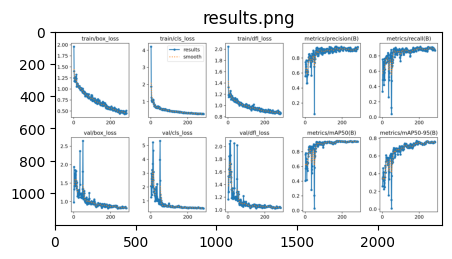

In [13]:
results_display_function(path="/kaggle/working/runs/detect/Factory-Production-Line-Objects-Detect-Track-And-Count/results.png")

### **F1-Confidence Score & Curve :**

In [14]:
print("F1 score:", training_results.box.f1)

F1 score: [    0.89832]


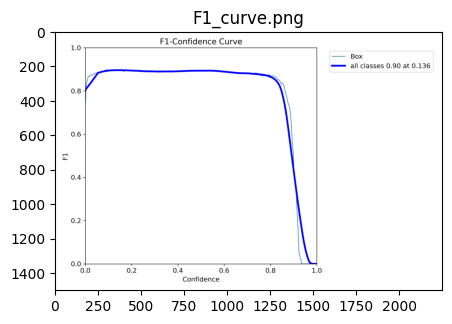

In [15]:
results_display_function(path="/kaggle/working/runs/detect/Factory-Production-Line-Objects-Detect-Track-And-Count/F1_curve.png")

## **Precision Scores & Curves :**

In [16]:
print("Precision Score:", training_results.box.p)

Precision Score: [    0.89197]


In [17]:
print("Class indices with average precision:", training_results.ap_class_index)

Class indices with average precision: [0]


In [18]:
print("Average precision for all classes:", training_results.box.all_ap)

Average precision for all classes: [[    0.94447     0.94178      0.9325       0.926     0.91757     0.90593     0.85022     0.72479     0.48086    0.061334]]


In [19]:
print("Average precision:", training_results.box.ap)

Average precision: [    0.76855]


In [20]:
print("Average precision at IoU=0.50:", training_results.box.ap50)

Average precision at IoU=0.50: [    0.94447]


In [21]:
print("Class indices for average precision:", training_results.box.ap_class_index)

Class indices for average precision: [0]


In [22]:
print("Mean precision:", training_results.box.mp)

Mean precision: 0.8919678672527266


In [23]:
print("Mean average precision:", training_results.box.map)

Mean average precision: 0.76854643512408


In [24]:
print("Mean average precision at IoU=0.50:", training_results.box.map50)

Mean average precision at IoU=0.50: 0.9444678905709434


In [25]:
print("Mean average precision at IoU=0.75:", training_results.box.map75)

Mean average precision at IoU=0.75: 0.9059347176661998


In [26]:
print("Mean average precision for different IoU thresholds:", training_results.box.maps)

Mean average precision for different IoU thresholds: [    0.76855     0.76855]


In [27]:
print("Precision values:", training_results.box.prec_values)

Precision values: [[          1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1
            1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1
            1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1           1
            1           1           1   

#### **Precision-Confidence Curve :**

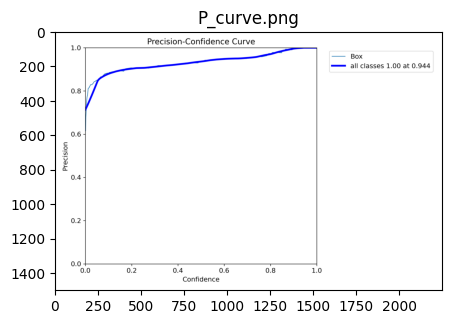

In [28]:
results_display_function(path="/kaggle/working/runs/detect/Factory-Production-Line-Objects-Detect-Track-And-Count/P_curve.png")

#### **Precision-Recall Curve :**

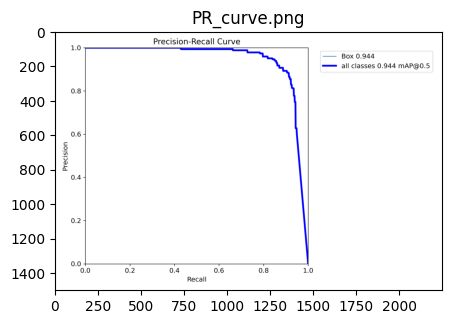

In [29]:
results_display_function(path="/kaggle/working/runs/detect/Factory-Production-Line-Objects-Detect-Track-And-Count/PR_curve.png")

### **Recall Scores & Curve :**

In [30]:
print("Recall:", training_results.box.r)

Recall: [    0.90476]


In [31]:
print("Mean recall:", training_results.box.mr)

Mean recall: 0.9047619047619048


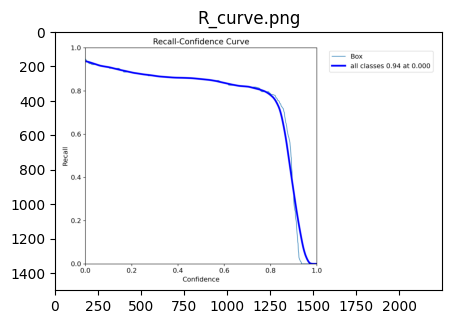

In [32]:
results_display_function(path="/kaggle/working/runs/detect/Factory-Production-Line-Objects-Detect-Track-And-Count/R_curve.png")

### **Confusion Matrix :**

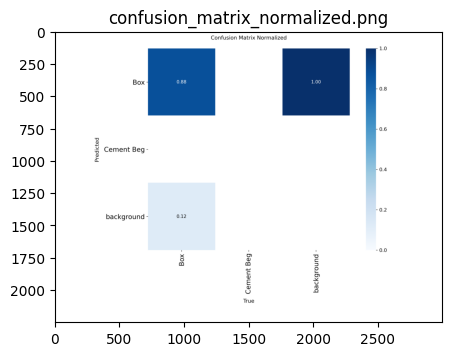

In [33]:
results_display_function(path="/kaggle/working/runs/detect/Factory-Production-Line-Objects-Detect-Track-And-Count/confusion_matrix_normalized.png")

### **Labels & Labels-Correlogram :**

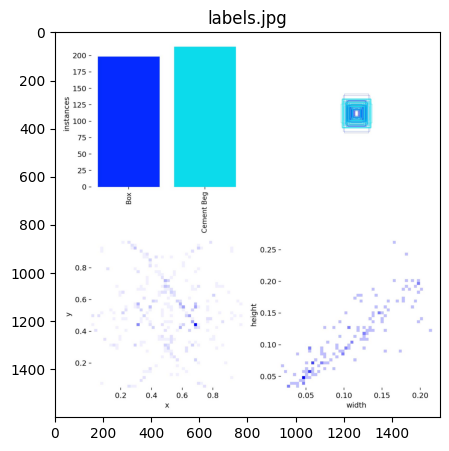

In [34]:
results_display_function(path="/kaggle/working/runs/detect/Factory-Production-Line-Objects-Detect-Track-And-Count/labels.jpg")

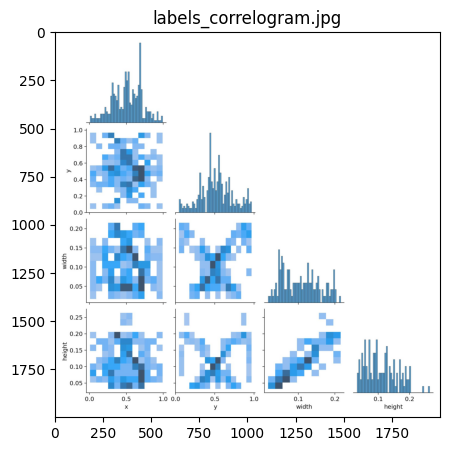

In [35]:
results_display_function(path="/kaggle/working/runs/detect/Factory-Production-Line-Objects-Detect-Track-And-Count/labels_correlogram.jpg")

### **Some Train Batch Sample Result :**

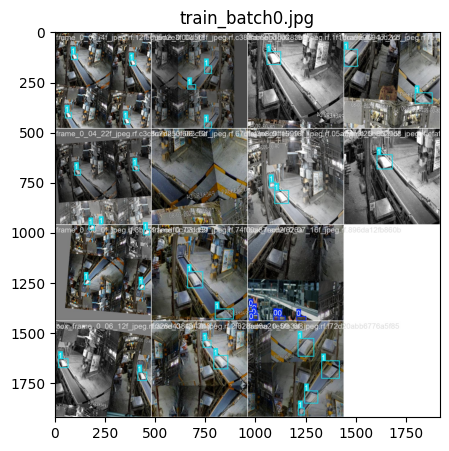

In [36]:
results_display_function(path="/kaggle/working/runs/detect/Factory-Production-Line-Objects-Detect-Track-And-Count/train_batch0.jpg")

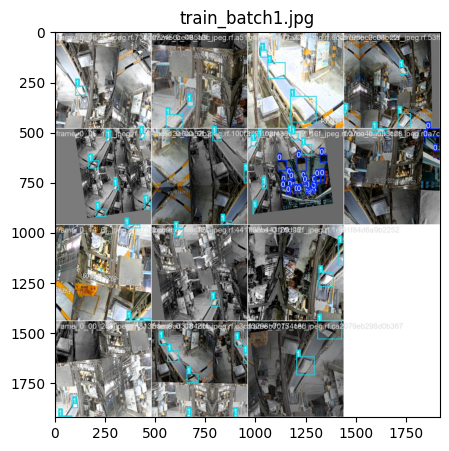

In [37]:
results_display_function(path="/kaggle/working/runs/detect/Factory-Production-Line-Objects-Detect-Track-And-Count/train_batch1.jpg")

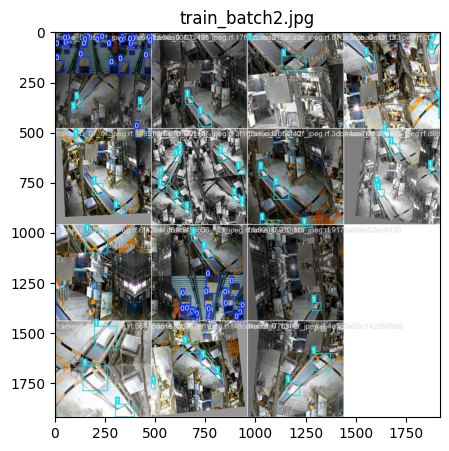

In [38]:
results_display_function(path="/kaggle/working/runs/detect/Factory-Production-Line-Objects-Detect-Track-And-Count/train_batch2.jpg")

### **Some Validation Batch Results :(labels & Predict)**

#### **Batch-0 (labels & Predict) :**

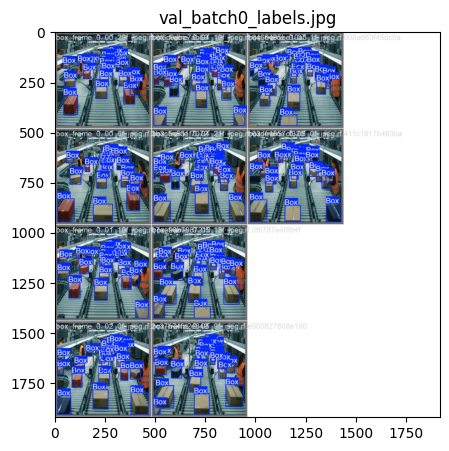

In [39]:
results_display_function(path="/kaggle/working/runs/detect/Factory-Production-Line-Objects-Detect-Track-And-Count/val_batch0_labels.jpg")

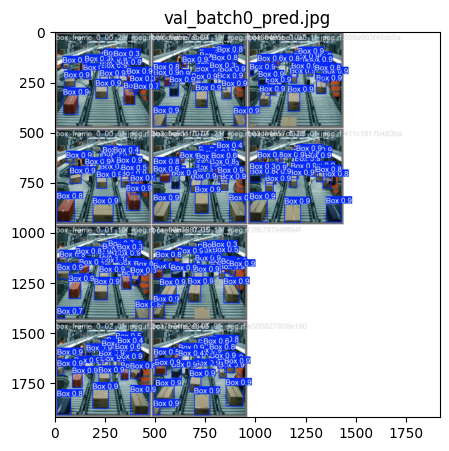

In [40]:
results_display_function(path="/kaggle/working/runs/detect/Factory-Production-Line-Objects-Detect-Track-And-Count/val_batch0_pred.jpg")

# **Test Best Model Function :**

In [44]:
def test_best_model(best_model_path, run_name, testing_images): 
    if not best_model_path or not os.path.exists(best_model_path):
        print("Trained model path is not found.")
        return None
    else:
        print("Continued the best model testing process :")
    
    # Load the best model 
    try:
        best_model=YOLO(best_model_path)
        print("Model loaded successfully.")
    except Exception as e:
        print(f"Error occurred during load the best model {e}")
        return None

    # Create a directory to save the inference result
    try:
        results_dir=f"/kaggle/working/inference/{run_name}_test_data"
        os.makedirs(results_dir, exist_ok=True)
        print("results_dir created  successfully.")
    except Exception as e:
        print(f"Error occurred during create the results_dir {e}")
        return None

    result_paths=[]
    
    # Run the prediction on each test data images and display results 
    for idx, img_path in enumerate(testing_images):
        filename = os.path.basename(img_path)
        print(f"\nProcessing: [{filename}]")
        try:
            results = best_model(img_path, save=True, project=results_dir, name=f"predict{idx+1}")
        except Exception as e:
            print(f"Error occurred during testing with the best model: {e}")
            continue 
        
        try:
            result_file_subdir=os.path.join(results_dir, f"predict{idx+1}")
            result_file_path=os.path.join(result_file_subdir, filename)
            result_paths.append(result_file_path)
        except Exception as e:
            print(f"Error occurred during save the results in this [{result_path}] path: {e}")
            continue
            
    return result_paths # return all process image path

# **Running Inference On The Fine-Tuned Model Using Test Data From Dataset :**

In [45]:
def load_test_data_from_roboflow_dataset(dataset_path, max_images):
    if not dataset_path or not os.path.exists(dataset_path):
        print("Dataset path is not found.")
        return None
    
    print("Continue the test data loading process:")

    # open data.yaml file
    try:
        with open(os.path.join(dataset_path,"data.yaml"), 'r') as f:
            yaml_file=yaml.safe_load(f)
        print("data.yaml loaded successfully.")
    except Exception as e:
        print(f"Error occurred during load the data.yaml file: {e}")
        return None 
    
    # Get the test images from dataset yaml file
    try:
        test_data_dir=None
        if 'test' in yaml_file:
            test_data_dir = yaml_file['test'] if os.path.isabs(yaml_file['test']) else os.path.join(dataset_path, yaml_file['test'])
        elif 'val' in yaml_file:
            test_data_dir = yaml_file['val'] if os.path.isabs(yaml_file['val']) else os.path.join(dataset_path, yaml_file['val'])
        else:
            print("Neither 'test' nor 'val' directories are specified in yaml file.")
            return None

        if not os.path.exists(test_data_dir):
            print(f"No valid test directory [{test_data_dir}] has been found.")
            return None

        if len(os.listdir(test_data_dir))== 0:
            print(f"Test directory [{test_data_dir}] is empty.")
            return None

        img_ext=('.jpg', '.png', '.jpeg', '.bmp', '.gif')
        load_images=[os.path.join(test_data_dir, img) 
                     for img in os.listdir(test_data_dir)
                     if os.path.isfile(os.path.join(test_data_dir, img)) # check for valid images
                     and img.lower().endswith(img_ext)] 
        
        # Take max images after filtering all valid images
        if load_images is not None:
            load_images = load_images[:max_images]
        
        if not load_images:
            print("Not valid Images have been found in test directory.")
            return None
        
        print("Images loaded successfully for testing.")
    except Exception as e:
        print(f"Error occurred during load the images from data.yaml file: {e}")
        return None 
    
    return load_images

In [46]:
# testing_images = load_test_data_from_roboflow_dataset(dataset_path="/kaggle/working/Track-Object-3",max_images=10) # if we want to run inference on first 10 val or test images
testing_images=load_test_data_from_roboflow_dataset(dataset_path="/kaggle/working/Track-Object-3",max_images=None) # if we want to run inference on all val or test images

Continue the test data loading process:
data.yaml loaded successfully.
Images loaded successfully for testing.


In [48]:
result_paths = test_best_model(best_model_path="/kaggle/working/runs/detect/Factory-Production-Line-Objects-Detect-Track-And-Count/weights/best.pt",
                               run_name=run_name,
                               testing_images=testing_images)

Continued the best model testing process :
Model loaded successfully.
results_dir created  successfully.

Processing: [box_frame_0_03_14f_jpeg.rf.1c87719e7a3114b5d6a5d454bf5c1269.jpg]

image 1/1 /kaggle/working/Track-Object-3/test/images/box_frame_0_03_14f_jpeg.rf.1c87719e7a3114b5d6a5d454bf5c1269.jpg: 640x640 21 Boxs, 36.8ms
Speed: 1.7ms preprocess, 36.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /kaggle/working/inference/Factory-Production-Line-Objects-Detect-Track-And-Count_test_data/predict1

Processing: [box_frame_0_06_3f_jpeg.rf.0b0672707f7d93c1f7f80d7f16874e8e.jpg]

image 1/1 /kaggle/working/Track-Object-3/test/images/box_frame_0_06_3f_jpeg.rf.0b0672707f7d93c1f7f80d7f16874e8e.jpg: 640x640 23 Boxs, 36.1ms
Speed: 2.2ms preprocess, 36.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /kaggle/working/inference/Factory-Production-Line-Objects-Detect-Track-And-Count_test_data/predict2

Processing: [box_frame_0

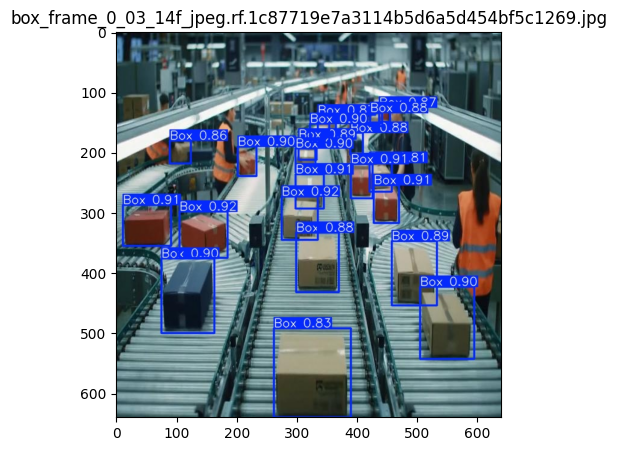

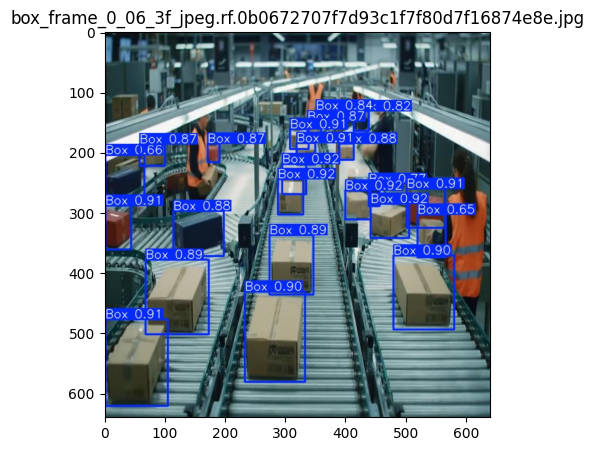

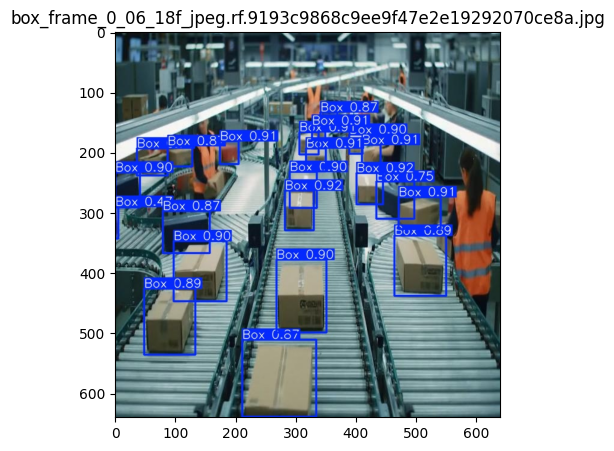

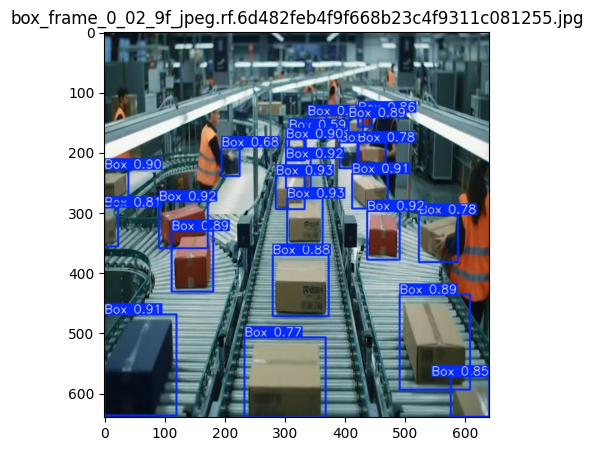

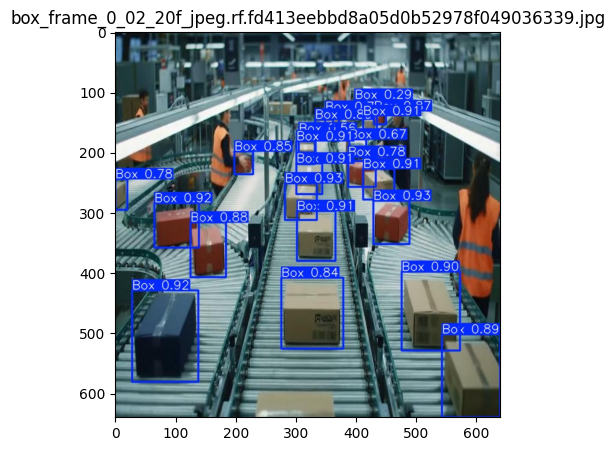

In [49]:
results_display_function(path=result_paths)

# **Running Inference On The Fine-Tuned Model Using Unseen Raw Data :**

In [50]:
def load_and_preprocess_unseen_data(raw_images_path, max_images, conv_output_dir):
    if not raw_images_path or not os.path.exists(raw_images_path):
        print("Images or Image path is not found.")
        return None
    
    print("Continue the unseen test data loading process:")

    img_ext=('.jpg', '.png', '.jpeg', '.bmp', '.gif', '.jfif')

    # create output directory for converted images 
    if not os.path.exists(conv_output_dir):
        os.makedirs(conv_output_dir)
    
    img_file = []

    # Check the input type (like file or directory)
    try:
        if os.path.isfile(raw_images_path) and raw_images_path.lower().endswith(img_ext):
            img_file=[raw_images_path] # Single image
        elif os.path.isdir(raw_images_path):
            img_file=[os.path.join(raw_images_path,img) for img in os.listdir(raw_images_path) if img.lower().endswith(img_ext)] 
            if max_images is not None: # it will execute when max_value will be given 
                img_file = img_file[:max_images] # Take first 'n' number of images 
        else:
            print("'Warning'....Provide a valid image file or directory.")
    
        if not img_file:
            print(f"Not valid Images have been found in test directory [{raw_images_path}].")
            return None

        # convert images to .jpg and save in conv_output_dir , skip for .jpg foles
        converted_img_paths=[]
        for img_path in img_file:
            base_name=os.path.splitext(os.path.basename(img_path))[0]
            out_path=os.path.join(conv_output_dir, f"{base_name}.jpg")

            # if file is already .jpg then use original path
            if img_path.lower().endswith('.jpg'):
                converted_img_paths.append(img_path)
                continue

            # open file and convert other fole to .jpg
            try:
                with Image.open(img_path) as img:
                    # convert to RGB for PNG file 
                    if img.mode in ('RGBA', 'LA', 'P'):
                        img= img.convert('RGB')
                    # save as .jpg file
                    img.save(out_path, 'JPEG', quality=95)
                converted_img_paths.append(out_path)
            except Exception as e:
                print(f"Error occurred during converting image {img_path}: {e}")
                continue 
                
        if not converted_img_paths:
            print("No images were loaded or converted.")
            return None

        print("Images loaded and converted to .jpg successfully and ready for testing.")
        return converted_img_paths
    
    except Exception as e:
        print(f"Error occurred during loading or converting images: {e}")
        return None

In [51]:
# img_file = load_and_preprocess_unseen_data(raw_images_path="/kaggle/input/test-data", max_images=5, conv_output_dir="/kaggle/working/converted_images") # if we take a directory of images and want to run inference on first 5 images
img_files = load_and_preprocess_unseen_data(raw_images_path="/kaggle/input/testing-data",
                                            max_images=None, 
                                            conv_output_dir="/kaggle/working/converted_images") # if we take a directory of images and want to run inference on all images 

Continue the unseen test data loading process:
Images loaded and converted to .jpg successfully and ready for testing.


In [54]:
un_result_paths = test_best_model(best_model_path="/kaggle/working/runs/detect/Factory-Production-Line-Objects-Detect-Track-And-Count/weights/best.pt",
                                  run_name=f"{run_name}_un", 
                                  testing_images=img_files)

Continued the best model testing process :
Model loaded successfully.
results_dir created  successfully.

Processing: [box_frame_0_02_20f_jpeg.rf.fd413eebbd8a05d0b52978f049036339.jpg]

image 1/1 /kaggle/input/testing-data/box_frame_0_02_20f_jpeg.rf.fd413eebbd8a05d0b52978f049036339.jpg: 640x640 22 Boxs, 36.9ms
Speed: 1.6ms preprocess, 36.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /kaggle/working/inference/Factory-Production-Line-Objects-Detect-Track-And-Count_un_test_data/predict1

Processing: [frame_0_20_6f.jpg]

image 1/1 /kaggle/working/converted_images/frame_0_20_6f.jpg: 480x640 3 Cement Begs, 30.0ms
Speed: 1.8ms preprocess, 30.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /kaggle/working/inference/Factory-Production-Line-Objects-Detect-Track-And-Count_un_test_data/predict2

Processing: [frame_0_21_10f.jpg]

image 1/1 /kaggle/working/converted_images/frame_0_21_10f.jpg: 480x640 3 Cement Begs, 23.5ms
S

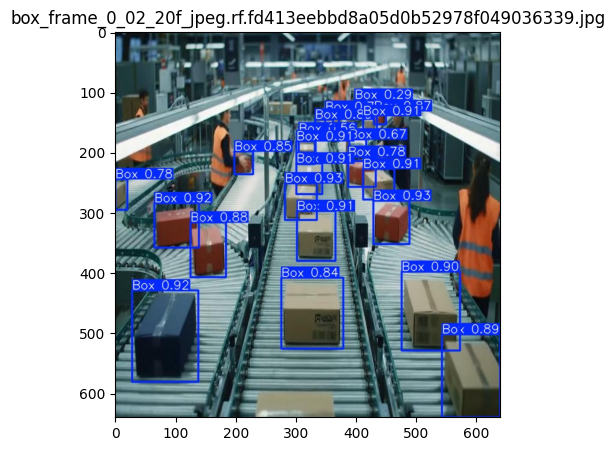

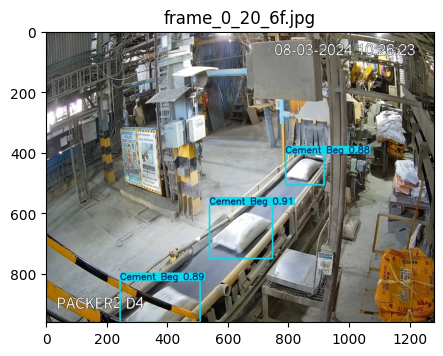

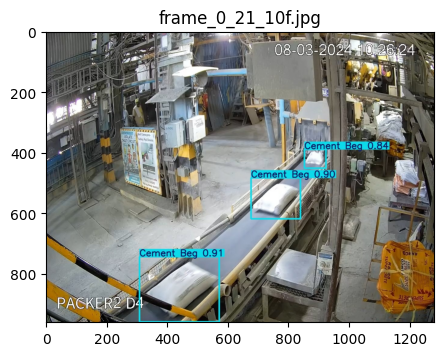

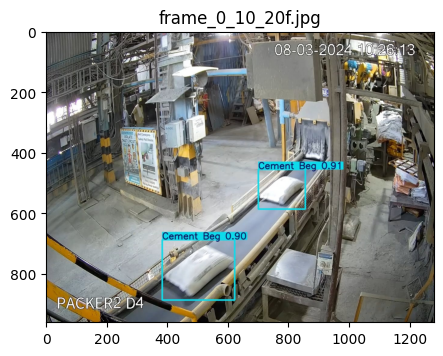

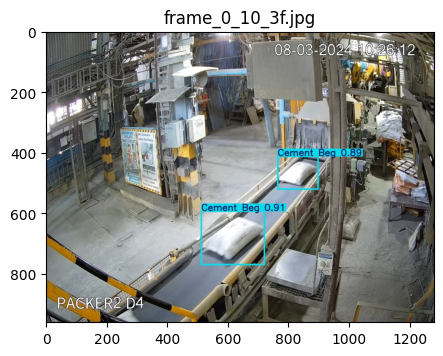

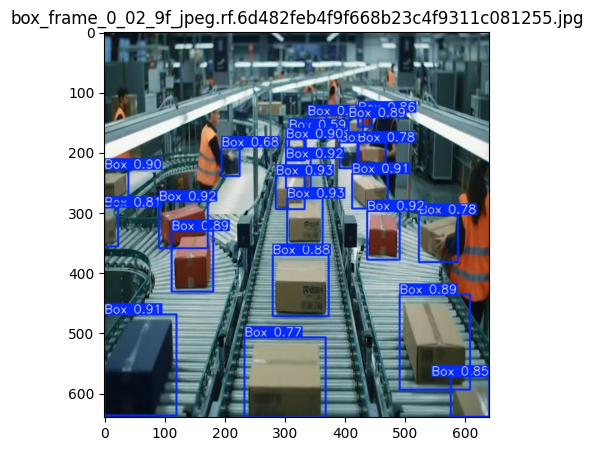

In [55]:
results_display_function(path=un_result_paths)

# **Running Inference On The Fine-Tuned Model Using Unseen Video Data :**

In [56]:
def test_best_model_on_videos(best_model_path, raw_videos_path, output_dir, frame_interval=1, conf_threshold=0.20):

    # Ensure the best model path exists
    if not os.path.exists(best_model_path):
        print(f"Best model path does not exist: [{best_model_path}]")
        return None

    # Ensure the raw videos path exists
    if not os.path.exists(raw_videos_path):
        print(f"Raw videos path does not exist: [{raw_videos_path}]")
        return None

    # Load the best model
    try:
        model = YOLO(best_model_path)
        print(f"Successfully loaded the model from [{best_model_path}]")
    except Exception as e:
        print(f"Error occurred during load the model from [{best_model_path}]: {e}")
        return None
    
    # Check if input is a single file or a directory
    vdo_format = ('.mp4', '.avi', '.mov', '.mkv', '.webm')
    try:
        if os.path.isfile(raw_videos_path) and raw_videos_path.lower().endswith(vdo_format):
            vdo_files = [raw_videos_path]
            print(f"Found [{len(vdo_files)}] video files to process.")
        elif os.path.isdir(raw_videos_path):
            vdo_files = [os.path.join(raw_videos_path, f) for f in os.listdir(raw_videos_path) if f.lower().endswith(vdo_format)]
            print(f"Found [{len(vdo_files)}] video files in the directory: [{raw_videos_path}]")
        else:
            print(f"Invalid raw videos path: [{raw_videos_path}]")
            return None
        
        if not vdo_files:
            print("No valid video files found in the specified path.")
            return None
        
        # Filter out any empty files
        valid_vdo_files = [f for f in vdo_files if os.path.getsize(f) > 0]
        if len(valid_vdo_files) != len(vdo_files):
            print(f"Filtered out [{len(vdo_files) - len(valid_vdo_files)}] empty files")
        vdo_files = valid_vdo_files
        print(f"Valid video files: [{len(vdo_files)}]")
        # Ensure there are valid video files to process
        if not vdo_files:
            print("No valid video files found after filtering.")
            return None

    except Exception as e:
        print(f"Error occurred during accessing video files in [{raw_videos_path}]: {e}")
        return None
    
    # Create output directory
    try:
        os.makedirs(output_dir, exist_ok=True)
        print(f"Output directory created or exist at: [{output_dir}]")
    except Exception as e:
        print(f"Error occurred during create output directory [{output_dir}]: {e}")    
        return None
    
    # Process each video file
    print(f"Running inference on [{len(vdo_files)}] video........................")
    
    for vdo_idx, vdo_path in enumerate(vdo_files):
        vdo_filename = os.path.basename(vdo_path)
        vdo_name = os.path.splitext(vdo_filename)[0]
        print(f"Processing video [{vdo_idx + 1}/{len(vdo_files)}]: {vdo_filename}")
        
        # Initialize video objects
        vdo = None
        out = None
        
        try:
            # Create output video save path
            output_video_path = os.path.join(output_dir, f"{vdo_name}_predictions.mp4")
            print(f"Output video will be saved to: [{output_video_path}]")
        
            # Open the video file
            vdo = cv2.VideoCapture(vdo_path)
            if not vdo.isOpened():
                print(f"Error occurred during open video file: [{vdo_path}]")
                continue
            print(f"Successfully opened video file: [{vdo_path}]")

            # Get video properties
            fps = vdo.get(cv2.CAP_PROP_FPS)
            width = int(vdo.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(vdo.get(cv2.CAP_PROP_FRAME_HEIGHT))
            total_frames = int(vdo.get(cv2.CAP_PROP_FRAME_COUNT))
            print(f"Video properties - FPS: [{fps}], Width: [{width}], Height: [{height}], Total Frames: [{total_frames}]")
        
            # Initialize video writer
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
            if not out.isOpened():
                print(f"Error occurred during initialize video writer for [{output_video_path}]")
                continue
            print(f"Video writer initialized successfully for output video: [{output_video_path}]")

            # Process frames
            frame_count = 0
            processed_count = 0
            
            print(f"Starting frame processing for video: [{vdo_filename}]")
       
            while vdo.isOpened():
                ret, frame = vdo.read()
                if not ret:
                    print(f"End of video or error reading frame at count: [{frame_count}]")
                    break
                
                # Process every 'frame_interval' frames
                if frame_count % frame_interval == 0:
                    try:
                        # Run prediction on the current frame
                        print(f"Processing frame [{frame_count}] for video: [{vdo_filename}]")
                        results = model.predict(frame, conf=conf_threshold, verbose=False)
                        
                        # Get the annotations from the results
                        annotated_frame = results[0].plot()
                        
                        # Save the frame with predictions
                        frames_dir = os.path.join(output_dir, "frames predictions")
                        os.makedirs(frames_dir, exist_ok=True)
                        frame_output_path = os.path.join(frames_dir, f"{vdo_name}_frame_{frame_count:06d}.jpg")
                        cv2.imwrite(frame_output_path, annotated_frame)  
                        print(f"Saved annotated frame to: [{frame_output_path}]")
                        
                        processed_count += 1
                        
                        # Print progress
                        if processed_count % 50 == 0:
                            progress = (processed_count * frame_interval / total_frames) * 100
                            print(f"Progress: {progress:.2f}% ({processed_count} processed frames, current frame: {frame_count}/{total_frames})")
                            
                    except Exception as e:
                        print(f"Error processing frame [{frame_count}] for video [{vdo_filename}]: {e}")
                        # Use original frame if processing fails
                        annotated_frame = frame
                        
                else:
                    # For frames we don't process, use the original frame
                    annotated_frame = frame
                
                # Write frame to output video (either processed or original)
                out.write(annotated_frame)
                if frame_count % frame_interval == 0:
                    print(f"Annotated frame [{frame_count}] written to output video.")
                frame_count += 1    
                    
        except Exception as e:
            print(f"Error occurred during processing video [{vdo_filename}]: {e}")
        
        finally:
            # Release resources safely
            if vdo is not None:
                try:
                    vdo.release()
                    print(f"Released video capture for video: [{vdo_filename}]")
                except Exception as e:  
                    print(f"Error occurred during releasing video capture for [{vdo_filename}]: {e}")
                    
            if out is not None:
                try:
                    out.release()
                    print(f"Released video writer for video: [{vdo_filename}]")
                except Exception as e:
                    print(f"Error occurred during releasing video writer for [{vdo_filename}]: {e}")
        
        print(f"Processed [{processed_count}] frames from video [{vdo_idx+1}/{len(vdo_files)}]")
        print(f"Output video saved to: [{output_video_path}]")
        
    print(f"All videos processed. Output saved to: [{output_dir}]")
    return output_dir

In [57]:
test_best_model_on_videos(best_model_path="/kaggle/working/runs/detect/Factory-Production-Line-Objects-Detect-Track-And-Count/weights/best.pt",
                          raw_videos_path="/kaggle/input/testing-data", 
                          output_dir=f"/kaggle/working/inference/{run_name}_video_test_data", 
                          frame_interval=1,
                          conf_threshold=0.20)

Successfully loaded the model from [/kaggle/working/runs/detect/Factory-Production-Line-Objects-Detect-Track-And-Count/weights/best.pt]
Found [2] video files in the directory: [/kaggle/input/testing-data]
Valid video files: [2]
Output directory created or exist at: [/kaggle/working/inference/Factory-Production-Line-Objects-Detect-Track-And-Count_video_test_data]
Running inference on [2] video........................
Processing video [1/2]: pac.mp4
Output video will be saved to: [/kaggle/working/inference/Factory-Production-Line-Objects-Detect-Track-And-Count_video_test_data/pac_predictions.mp4]
Successfully opened video file: [/kaggle/input/testing-data/pac.mp4]
Video properties - FPS: [24.0], Width: [1280], Height: [960], Total Frames: [722]
Video writer initialized successfully for output video: [/kaggle/working/inference/Factory-Production-Line-Objects-Detect-Track-And-Count_video_test_data/pac_predictions.mp4]
Starting frame processing for video: [pac.mp4]
Processing frame [0] for 

'/kaggle/working/inference/Factory-Production-Line-Objects-Detect-Track-And-Count_video_test_data'